# 使用高斯混合模型识别餐厅热点

In [48]:
import numpy as np
import pandas as pd

import sklearn.mixture as sm
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import os

data_path = os.environ.get('DATA_PATH')

## GMM Assumptions

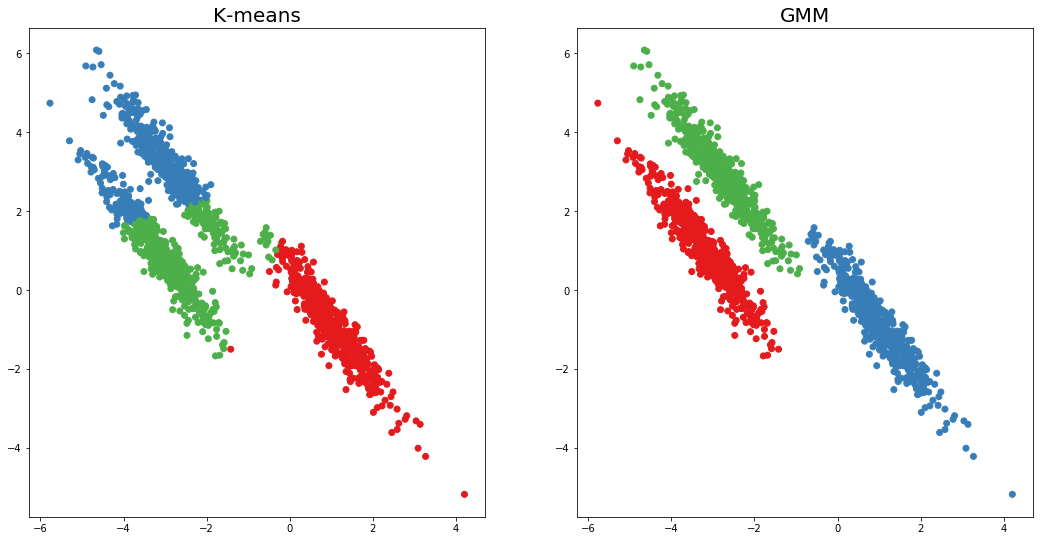

In [81]:
# Non spherical clusters 
plt.figure(figsize=(18, 9))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

# K-means
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(121)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred,cmap='Set1',vmin=0, vmax=7)
plt.title("K-means",size=20)

# GMM
gmm = sm.GaussianMixture(n_components=3, random_state=11,n_init=5)
y_pred = gmm.fit(X_aniso).predict(X_aniso)

plt.subplot(122)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred,cmap='Set1',vmin=0, vmax=7)
plt.title("GMM",size=20)

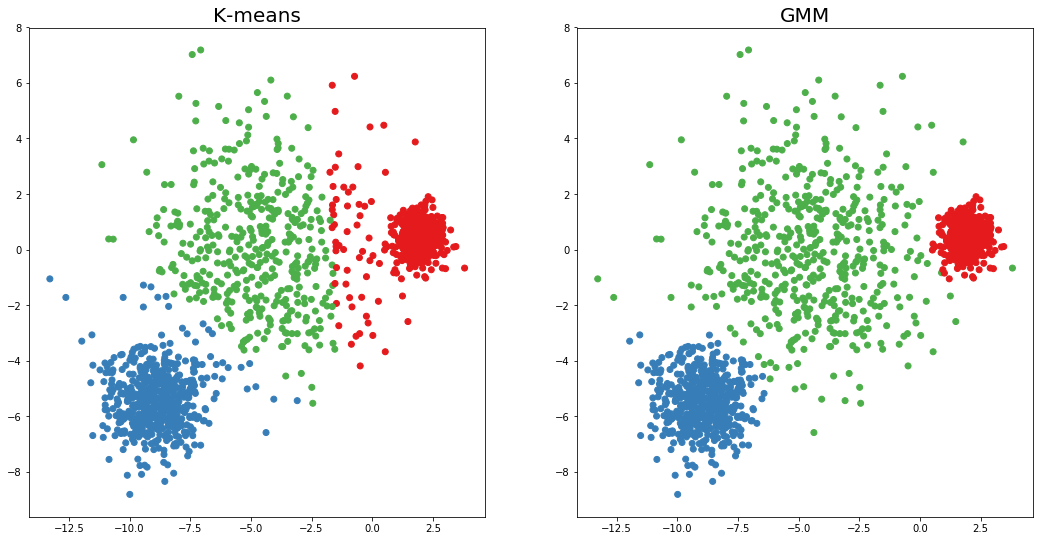

In [82]:
# Different variance
plt.figure(figsize=(18, 9))

n_samples = 1500
random_state = 170

X, y = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)

#K-means
labels = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=labels,cmap='Set1',vmin=0, vmax=7)
plt.title("K-means",size=20)

#GMM
gmm = sm.GaussianMixture(n_components=3, random_state=11,n_init=5)
labels = gmm.fit(X).predict(X)

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=labels,cmap='Set1',vmin=0, vmax=7)
plt.title("GMM",size=20)

## Dataset

In [1]:
import pandas as pd

data = pd.read_csv(data_path + "/yelp_data/toronto_restaurant.csv",usecols=['name','latitude','longitude','stars','review_count'])
print(len(data))
data.head()

7148


name  latitude  longitude  review_count  stars
0                     Alize Catering  43.71140  -79.39934            12    3.0
1             Chula Taberna Mexicana  43.66926  -79.33590            39    3.5
2                    Sunnyside Grill  43.78182  -79.49043             3    5.0
3  Bampot House of Tea & Board Games  43.66158  -79.40888            55    4.0
4                       Thai Express  43.77488  -79.49462             5    3.0

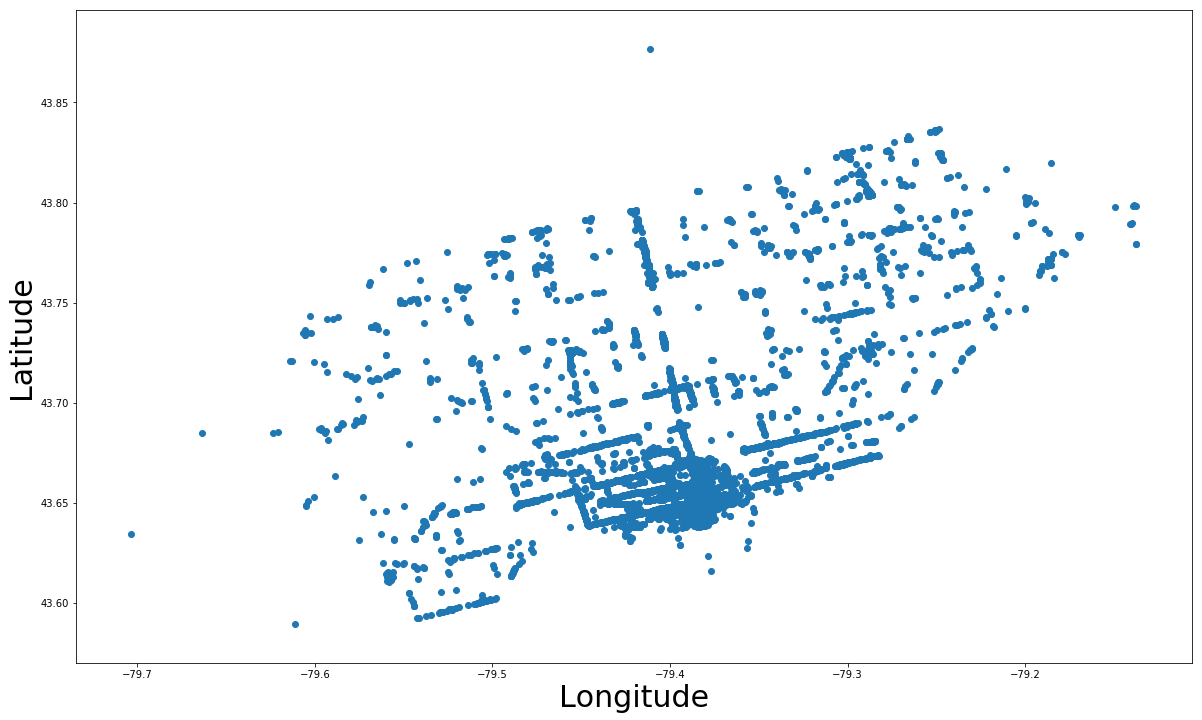

In [75]:
# Different variance
plt.figure(figsize=(20, 12))

plt.subplot(111)
plt.scatter(data['longitude'],data['latitude'])
plt.xlabel('Longitude',size=30)
plt.ylabel('Latitude',size=30)

## Fitting the clusters

In [2]:
import sklearn.mixture as sm
import matplotlib.pyplot as plt
%matplotlib inline

def plot_gmm(n):
    """
    Train a GMM using n clusters and plot the results
    
    Parameters
    ----------
    n : int
        Number of clusters
    """
    
    # Fit gmm and get labels
    x = data[['longitude','latitude']].values
    gmm = sm.GaussianMixture(n_components=n, random_state=11,n_init=5)
    labels = gmm.fit(x).predict(x)
    
    # assign a colour to each label
    colour = ['#f54242','#4287f5','#f59942','#f5f242','#69f542','#b342f5']
    # colour = ['#4287f5','#f59942','#f5f242', '#f54242' ,'#b342f5','#69f542']
    c = [colour[l] for l in labels]
    
    # scatter plot
    plt.figure(figsize=(20, 12))
    plt.scatter(x=x[:, 0], y=x[:, 1], c=c, s=40, cmap='Set1', zorder=1)
    plt.title('Number of Clusters: {}'.format(n),size=30)
    plt.xlabel('Longitude',size=30)
    plt.ylabel('Latitude',size=30)

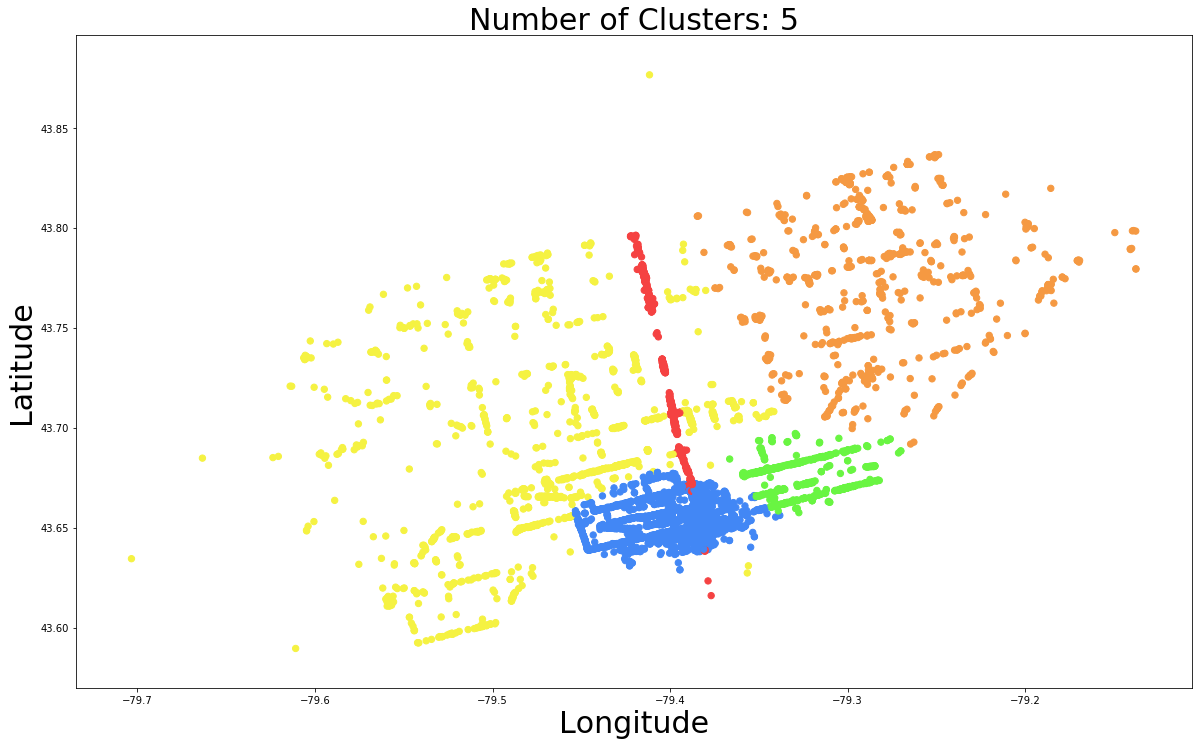

In [3]:
plot_gmm(5)

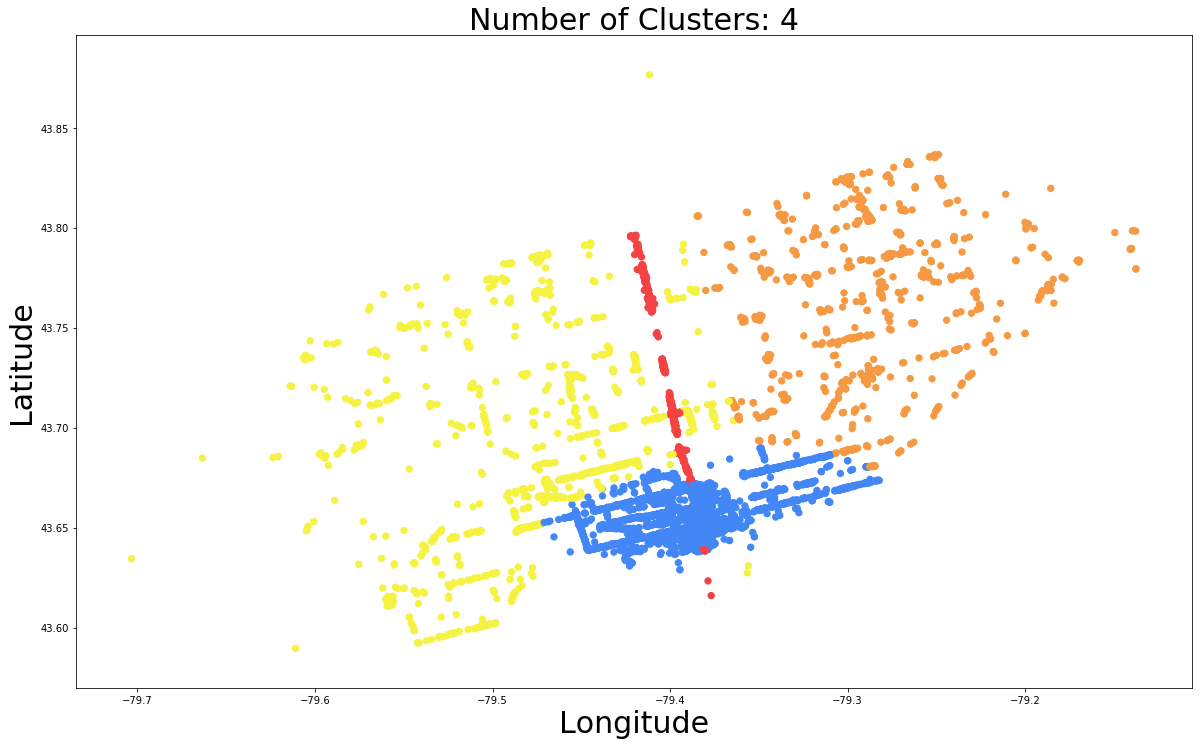

In [73]:
plot_gmm(4)

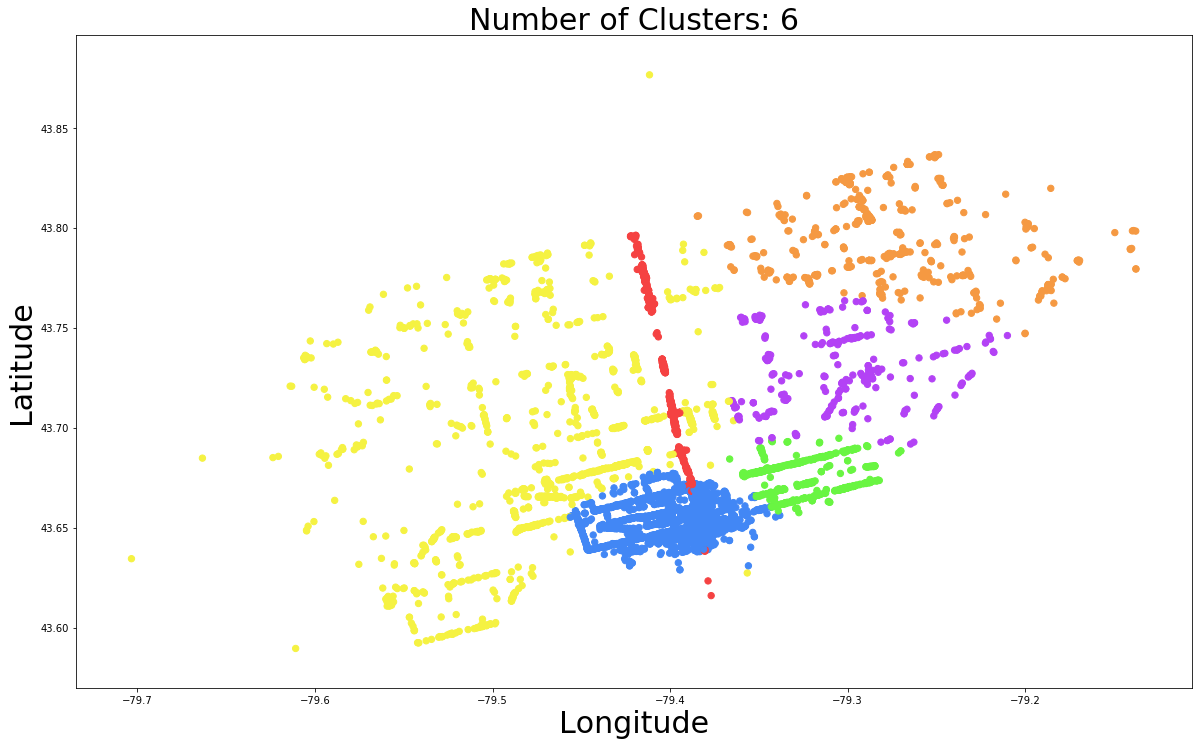

In [77]:
plot_gmm(6)

## Analyse Clusters

In [4]:
import folium

# Get gmm predictions
x = data[['longitude','latitude']].values
gmm = sm.GaussianMixture(n_components=5, random_state=11,n_init=5)
labels = gmm.fit(x).predict(x)

# create folium map 
m = folium.Map(
    location=[43.77923, -79.41731999999998],
    zoom_start=12,
    tiles='Stamen Terrain'
)

colour = ['#f54242','#4287f5','#f59942','#f5f242','#69f542','#b342f5']

# add markers to map 
for i in range(len(x)):
    lon = x[i][0]
    lat = x[i][1]
    label = labels[i]
    
    # assign colour based on label 
    c = colour[label]
    
    # add marker
    folium.CircleMarker(location=[lat,lon],
                        radius=2,
                        color=c,
                        fill_color=c).add_to(m) 

m.save('../figures/map.html')
# display map
m

In [5]:
# average 
data['label'] = [l for l in labels]
data.head()

name  latitude  longitude  review_count  \
0                     Alize Catering  43.71140  -79.39934            12   
1             Chula Taberna Mexicana  43.66926  -79.33590            39   
2                    Sunnyside Grill  43.78182  -79.49043             3   
3  Bampot House of Tea & Board Games  43.66158  -79.40888            55   
4                       Thai Express  43.77488  -79.49462             5   

   stars  label  
0    3.0      0  
1    3.5      4  
2    5.0      3  
3    4.0      1  
4    3.0      3

In [6]:
data.groupby(['label']).agg(['mean','std'])[['review_count','stars']]

review_count                stars          
              mean        std      mean       std
label                                            
0        38.163961  52.399721  3.314123  0.707069
1        54.668241  90.303468  3.432808  0.717025
2        27.030667  42.384915  3.307333  0.767245
3        23.437014  35.128030  3.463841  0.790542
4        31.412536  46.345233  3.521137  0.761715

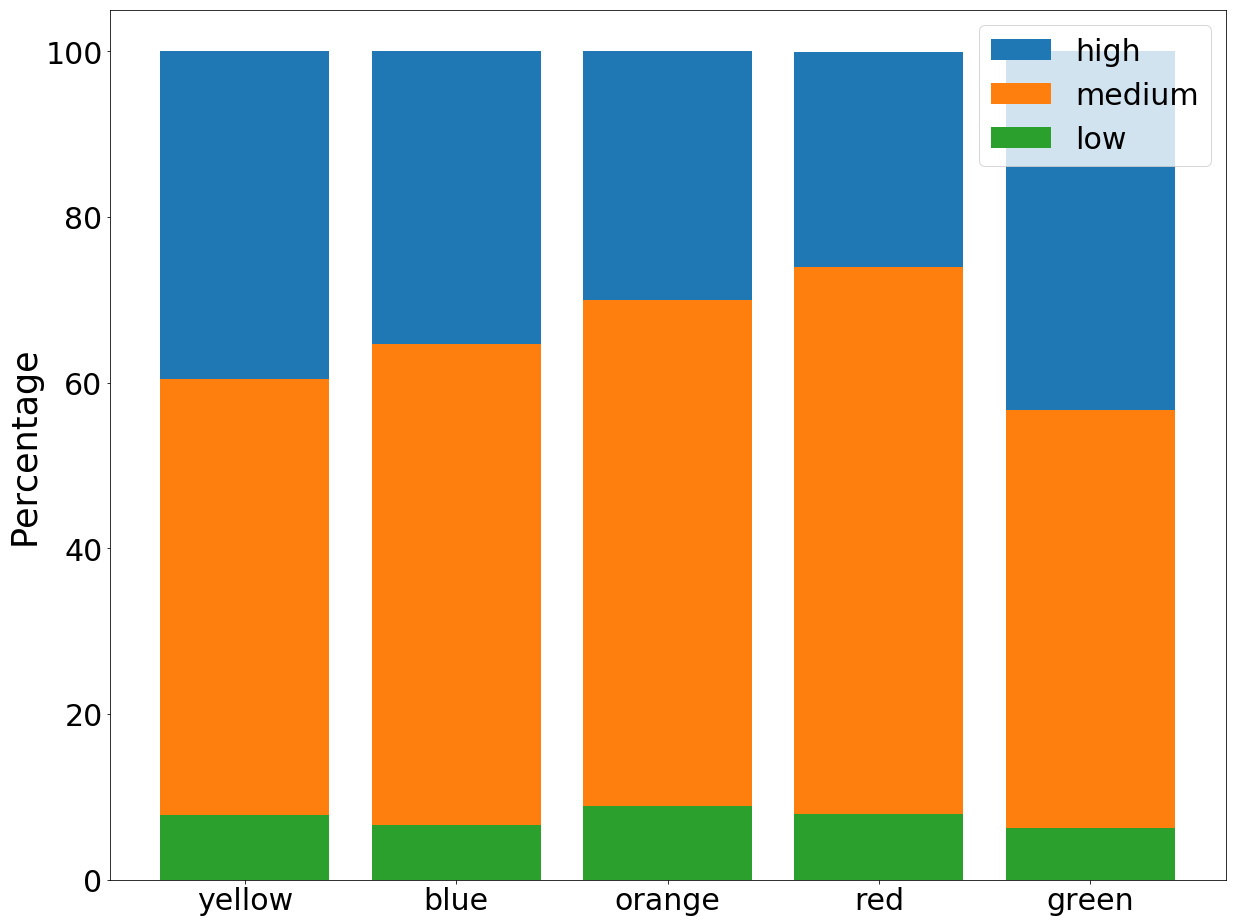

In [96]:
# Copy results below into excel to calculate proportions
data.groupby(['label','stars']).agg(['count'])[['name']]


labels = ['yellow', 'blue', 'orange', 'red','green'] 
low = [7.78, 6.64, 8.93,7.95, 6.27]
medium = np.add(low,[52.64, 58.03, 61.07,66.07 , 50.44])
high = np.add(medium,[39.58,35.33,30.00,25.97,43.29])


plt.figure(figsize=(20, 16))
plt.bar(labels,high,label='high')
plt.bar(labels,medium,label='medium')
plt.bar(labels,low,label='low')

# plt.xlabel('Restaurant Cluster',size=20)
plt.xticks(fontsize=30)
plt.ylabel('Percentage',size=35)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)

plt.savefig('../figures/rating.png',format='png')

In [103]:
data['label'] = [l for l in labels]
data.head()

name  latitude  longitude  review_count  \
0                     Alize Catering  43.71140  -79.39934            12   
1             Chula Taberna Mexicana  43.66926  -79.33590            39   
2                    Sunnyside Grill  43.78182  -79.49043             3   
3  Bampot House of Tea & Board Games  43.66158  -79.40888            55   
4                       Thai Express  43.77488  -79.49462             5   

   stars  label  
0    3.0     16  
1    3.5      6  
2    5.0      4  
3    4.0      2  
4    3.0      4